In [ ]:
import numpy as np
import os
from PIL import Image
from PIL import UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
parasitized = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
uninfected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/')

In [ ]:
height, width = 32, 32
x = []
y = []

In [ ]:
for i in uninfected:
    try:
        img = Image.open("../input/cell-images-for-detecting-malaria/cell_images/Uninfected/" + i).convert('RGB')
        img = img.resize((height,width))
        x.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [ ]:
for i in parasitized:
    try:
        img = Image.open("../input/cell-images-for-detecting-malaria/cell_images/Parasitized/" + i).convert('RGB')
        img = img.resize((height,width))
        x.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [ ]:
x = np.asarray(x)
y = np.asarray(y)
print("shapes of training data and label")
print(x.shape, y.shape)
x = x.astype('float32')
x /= 255

shapes of training data and label
(27558, 32, 32, 3) (27558,)


In [ ]:
total_classes = 2
labels = keras.utils.to_categorical(y, total_classes)
print(labels[0])

[0. 1.]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size = 0.2, random_state=5)
print("Total images in the dataset",len(y_train)+len(y_test))
print("Training images {}".format(len(x_train)))
print('Test images {}'.format(len(x_test)))

Total images in the dataset 27558
Training images 22046
Test images 5512


In [ ]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(2, 2),activation='sigmoid',input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(30, kernel_size=(3,3), activation='sigmoid'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(128, activation='sigmoid'))

model.add(Dropout(0.2))

model.add(Dense(50, activation='sigmoid'))

model.add(Dense(2, activation='softmax'))

2022-06-16 13:07:24.405178: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 20)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 30)        5430      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1080)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1080)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 30
epochs = 50

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='malaria_cnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_test, y_test))

2022-06-16 13:07:55.454829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
735/735 [==============================] - 11s 13ms/step - loss: 0.6981 - accuracy: 0.5031 - val_loss: 0.6916 - val_accuracy: 0.5053

Epoch 00001: val_loss improved from inf to 0.69164, saving model to malaria_cnn.h5
Epoch 2/50
735/735 [==============================] - 9s 12ms/step - loss: 0.6793 - accuracy: 0.5602 - val_loss: 0.6525 - val_accuracy: 0.6074

Epoch 00002: val_loss improved from 0.69164 to 0.65247, saving model to malaria_cnn.h5
Epoch 3/50
735/735 [==============================] - 9s 13ms/step - loss: 0.6404 - accuracy: 0.6321 - val_loss: 0.6215 - val_accuracy: 0.6468

Epoch 00003: val_loss improved from 0.65247 to 0.62145, saving model to malaria_cnn.h5
Epoch 4/50
735/735 [==============================] - 9s 12ms/step - loss: 0.6194 - accuracy: 0.6563 - val_loss: 0.5975 - val_accuracy: 0.6901

Epoch 00004: val_loss improved from 0.62145 to 0.59753, saving model to malaria_cnn.h5
Epoch 5/50
735/735 [==============================] - 9s 13ms/step - loss: 0.60

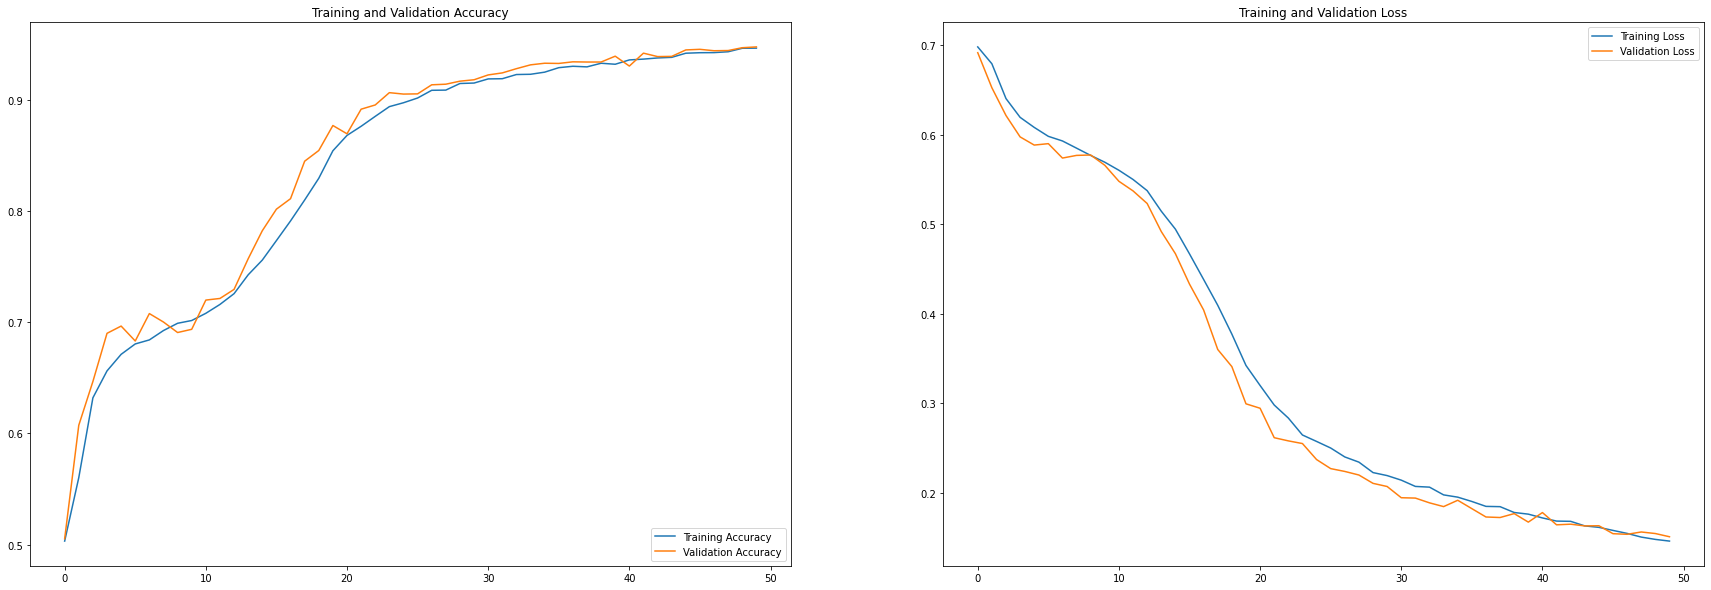

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

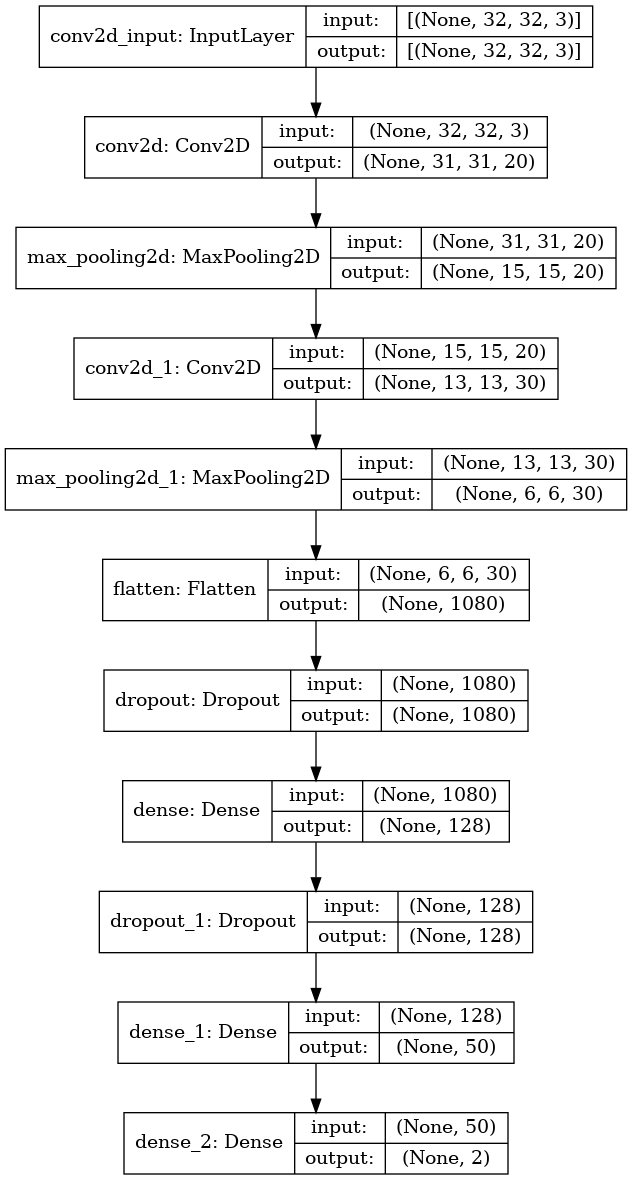

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('malaria_cnn.h5')
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1505991816520691
Test accuracy: 0.9479317665100098


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.96      0.93      0.95      2727
   Parasited       0.93      0.97      0.95      2785

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



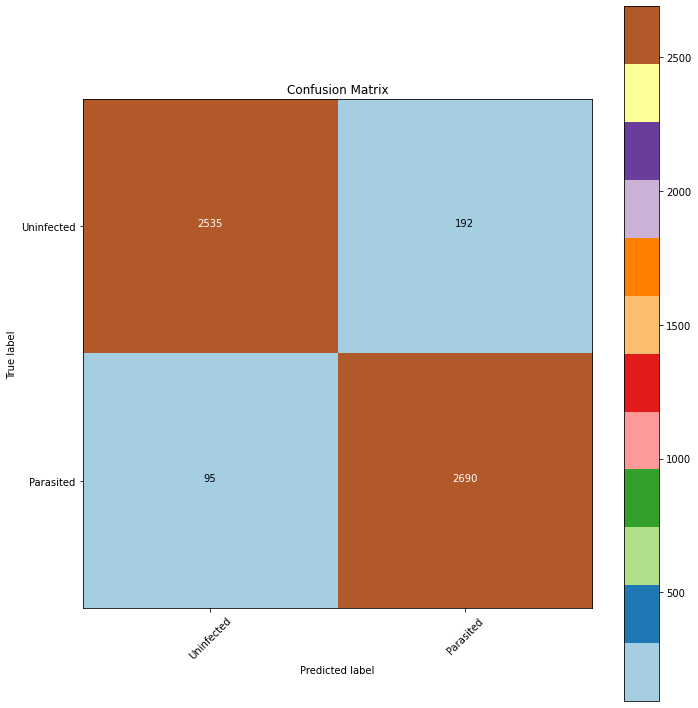

In [ ]:
import numpy as np

y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Uninfected", "Parasited"]

Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))